### 自动求导

In [3]:
#对y = x.Tx关于列向量x求导
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [4]:
#存储梯度
x.requires_grad_(True)#等价于x = torch.arange(4.0,requires_grad=True)
x.grad#默认值是None

In [5]:
y = torch.dot(x,x)
y
#PyTorch隐式地构造计算图，grad_fn用于记录梯度计算

tensor(14., grad_fn=<DotBackward0>)

##### 通过调用反向传播函数来自动计算y关于x每个分量的梯度

In [6]:
y.backward()
x.grad

tensor([0., 2., 4., 6.])

In [7]:
x.grad==2*x#验证

tensor([True, True, True, True])

In [8]:
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()#如果没有这一步结果就会加累上之前的梯度值，变为[1,5,9,13]
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [9]:
x.grad.zero_()
y=x*x#哈达玛积，对应元素相乘

#在深度学习中我们一般不计算微分矩阵
#而是计算批量中每个样本单独计算的偏导数之和

y.sum().backward()#等价于y.backword(torch.ones(len(x)))
x.grad

tensor([0., 2., 4., 6.])

##### 将某些计算移动到记录的计算图之外

In [10]:
# 后可用于用于将神经网络的一些参数固定住
x.grad.zero_()
y = x*x
u = y.detach()#把y当作常数
z = u*x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [11]:
x.grad.zero_()
y.sum().backward()
x.grad == 2*x

tensor([True, True, True, True])

##### 即使构建函数的计算图需要用过Python控制流，仍然可以计算得到的变量的梯度
##### 这也是隐式构造的优势，因为它会存储梯度计算的计算图，再次计算时执行反向过程就可以

In [50]:
def f(a):
    b = a * 2
    while b.norm()<1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(),requires_grad=True)
d = f(a)
d.backward()

a.grad == d / a

tensor(True)

## 练习

###### 1.为什么计算二阶导数比一阶导数的开销要更大？

二阶导数是在一阶导数的基础上进行的，开销自然更大

###### 2.在运行反向传播函数之后，立即再次运行它，看看会发生什么。

"RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward."

说明不能连续两次运行,pytorch使用的是动态计算图,反向传播函数运行一次后计算图就被释放了

###### 只需要在函数接口将参数retain_graph设为True即可

In [51]:
def f(a):
    b = a * 2
    while b.norm()<1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c
a.grad.zero_()
a = torch.randn(size=(),requires_grad=True)#size=0表示a是标量
d = f(a)
#d.backward(retain_graph=True)
#a.grad
d.backward()
a.grad

tensor(4096.)

###### 3.在控制流的例子中，我们计算d关于a的导数，如果我们将变量a更改为随机向量或矩阵，会发生什么？此时，计算结果f(a)不再是标量。结果会发生什么？我们如何分析这个结果？

backward函数的机制本身不允许张量对张量求导，如果输入是向量或矩阵，需要将其在各个分量上求和，变为标量；所以还需要传入一个与输入同型的张量

In [53]:
def f(a):
    b = a * 2
    while b.norm()<1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c
a.grad.zero_()
a = torch.randn(10,requires_grad=True)
d = f(a)
#d.backward(retain_graph=True)
#a.grad
#d.backward()#RuntimeError: grad can be implicitly created only for scalar outputs
d.sum().backward()#需要加上.sum()否则会报错 
a.grad

tensor([51200., 51200., 51200., 51200., 51200., 51200., 51200., 51200., 51200.,
        51200.])

###### 4.重新设计一个求控制流梯度的例子。运行并分析结果。

In [56]:
def h(x):
    y = x * x
    while y.norm() < 2500:
        y = y * 2
    if y.sum() < 0:
        c = 100*y
    else:
        c = y
    return c
x.grad.zero_()
x = torch.randn(size=(),requires_grad=True)
y = h(x)
y.backward()
x.grad

tensor(-3311.5398)

###### 5.使f(x)=sin(x)，绘制f(x)和df(x)/dx的图像，其中后者不使用f'(x)=\cos(x)。

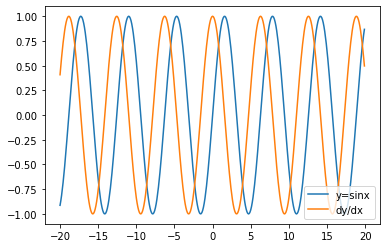

In [66]:
import matplotlib.pyplot as plt
x = torch.arange(-20,20,0.1,requires_grad=True,dtype=torch.float32)
y = torch.sin(x)
y.sum().backward()
plt.plot(x.detach(),y.detach(),label='y=sinx')
plt.plot(x.detach(),x.grad,label='dy/dx')
plt.legend(loc='lower right')